In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from scipy.stats import spearmanr
import os


Treino: (126, 18) | Teste (10): (16, 18)

📊 Evaluation for year 10:
Accuracy:  0.750
Precision: 1.000
Recall:    0.750
F1-score:  0.857
ROC–AUC:   nan

🏀 Top predicted coach changes (with actual result):
     year tmID     coachID  win_ratio  win_ratio_change  rank  pred_proba  \
132    10  SAC  whisejo99w   0.428571          0.197802     6    0.915187   
47     10  NYL  donovan99w   0.411765          0.058824     7    0.823976   
81     10  CHI   keyst99wc   0.470588          0.117647     5    0.766779   
18     10  SAC  bouceje01w   0.230769         -0.298643     6    0.650987   
105    10  WAS  plankju99w   0.470588          0.106952     4    0.621741   
94     10  DET  mahorri01w   0.548387          0.215054     3    0.609613   
62     10  MIN  gilloje01w   0.411765         -0.058824     5    0.589778   
61     10  PHO  gaineco01w   0.676471          0.205882     1    0.562737   
43     10  NYL  coylepa99w   0.352941         -0.205882     7    0.555465   
102    10  ATL  meadoma99w

/home/pjoca/Secretária/Universidade/4ºano/1ºsemestre/AC/ac-data-mining-project/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


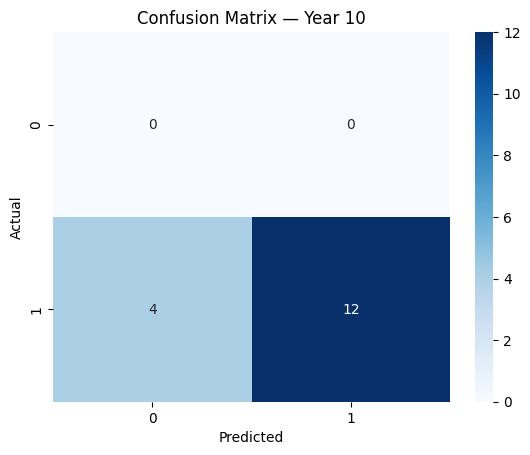

/tmp/ipykernel_8351/4192255265.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


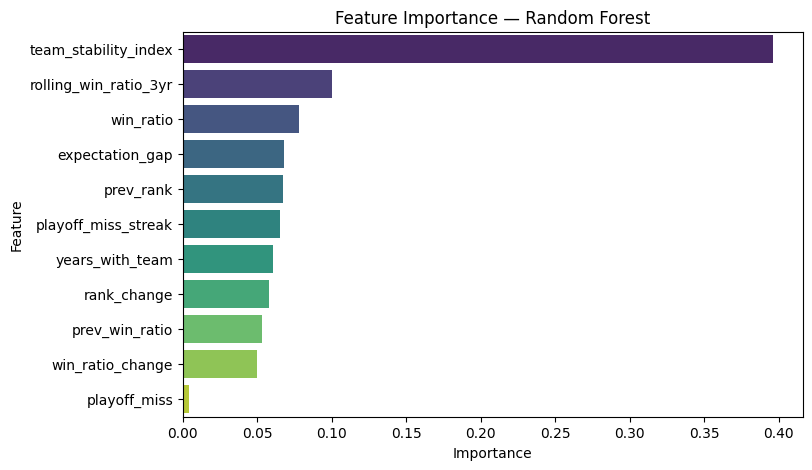


💡 Feature Influence (higher = more impact on firing prediction):
                  Feature  Importance
10   team_stability_index    0.396384
6   rolling_win_ratio_3yr    0.100213
0               win_ratio    0.077746
9         expectation_gap    0.067658
3               prev_rank    0.067462
7     playoff_miss_streak    0.065334
8         years_with_team    0.060587
4             rank_change    0.057831
1          prev_win_ratio    0.053245
2        win_ratio_change    0.049736
5            playoff_miss    0.003803

✅ Results saved to: data_models/predictions_model2.csv


In [7]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# Load prepared dataset
# ===============================================================
coach_df = pd.read_csv("data_models/coach_firing_dataset.csv")

# ===============================================================
# Choose target year
# ===============================================================

target_year = 10  # Change this as needed
train_data = coach_df[coach_df["year"] < target_year]
test_data  = coach_df[coach_df["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# ===============================================================
# Define features and target
# ===============================================================
features = [
    "win_ratio", "prev_win_ratio", "win_ratio_change",
    "prev_rank", "rank_change", "playoff_miss",
    "rolling_win_ratio_3yr", "playoff_miss_streak", "years_with_team", 
    "expectation_gap", "team_stability_index"
]

target = "coach_changed_next_year"

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# ===============================================================
# Predictions
# ===============================================================


test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.4
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


# ===============================================================
# Evaluation
# ===============================================================

# ===============================================================
# Risk categorization based on probability
# ===============================================================
def categorize_risk(prob):
    if prob > 0.6:
        return "High risk"
    elif prob > 0.4:
        return "Moderate risk"
    else:
        return "Low risk"

test_data.loc[:, "risk_level"] = test_data["pred_proba"].apply(categorize_risk)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
roc = roc_auc_score(y_test, test_data["pred_proba"])

print(f"\n📊 Evaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC–AUC:   {roc:.3f}")

# ===============================================================
# Display predictions
# ===============================================================

print("\n🏀 Top predicted coach changes (with actual result):")
print(
    test_data[[
        "year", "tmID", "coachID", "win_ratio", "win_ratio_change",
        "rank", "pred_proba", "risk_level",
        "predicted_change", "coach_changed_next_year"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(10)
)


# ===============================================================
# Confusion Matrix
# ===============================================================

# Column [0]: probability of class 0 → coach stays

# Column [1]: probability of class 1 → coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================================================
# Feature Importance
# ===============================================================

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\n💡 Feature Influence (higher = more impact on firing prediction):")
print(importance)

# ===============================================================
# Save predictions
# ===============================================================
os.makedirs("data_models", exist_ok=True)
test_data.to_csv("data_models/predictions_model2.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_model2.csv")


   year  accuracy        f1   roc_auc
0     3  0.631579  0.588235  0.815476
1     4  0.785714  0.666667  0.875000
2     5  0.823529  0.800000  0.833333
3     6  0.666667  0.615385  0.820000
4     7  0.714286  0.666667  0.895833
5     8  0.785714  0.727273  0.875000
6     9  1.000000  1.000000  1.000000
7    10  0.625000  0.769231       NaN


/home/pjoca/Secretária/Universidade/4ºano/1ºsemestre/AC/ac-data-mining-project/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


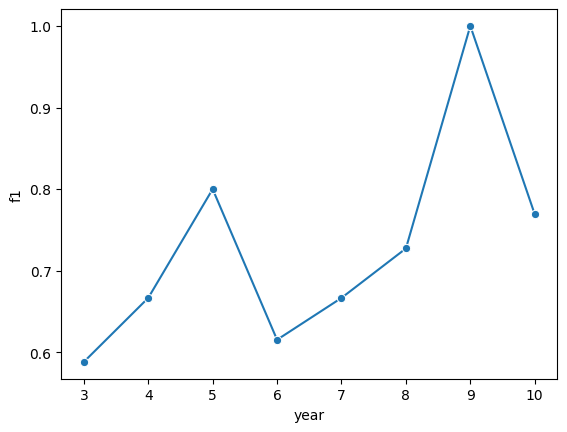

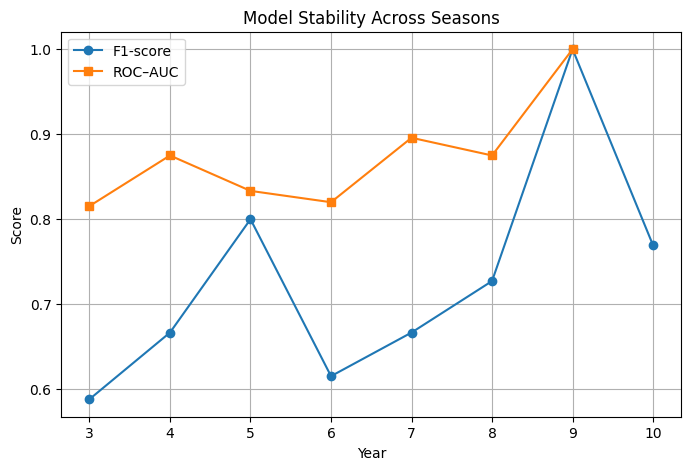

In [4]:
results = []
for yr in sorted(coach_df["year"].unique()):
    train = coach_df[coach_df["year"] < yr]
    test = coach_df[coach_df["year"] == yr]
    if len(test) < 5 or len(train) < 10:  # skip tiny folds
        continue

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    results.append({
        "year": yr,
        "accuracy": accuracy_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(results)
print(results_df)
sns.lineplot(data=results_df, x="year", y="f1", marker="o")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results_df["year"], results_df["f1"], marker="o", label="F1-score")
plt.plot(results_df["year"], results_df["roc_auc"], marker="s", label="ROC–AUC")
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("Model Stability Across Seasons")
plt.legend()
plt.grid(True)
plt.show()

